# check the inference code

In [2]:
%load_ext autoreload
%autoreload 2

In [159]:
import numpy as np
import pandas as pd

import tools as tl
import CRepDyn_w_STATIC as creps
import CRepDyn_w_DYN as crepd

import matplotlib.pyplot as plt
import networkx as nx
import importlib
import sktensor as skt
from sklearn import metrics
import cv_functions as cvfun
import time_glob as gl

%matplotlib inline

In [7]:
cmap = 'PuBuGn'

In [8]:
def flt(x,d=3):
    return round(x, d)

In [1084]:
def calculate_AUC(pred,data0,mask=None):
    # M = expected_Aija(U,V,W)+(eta*B[0,:,:].T)[np.newaxis,:,:]
    # M = expected_Aija(U,V,W)+eta*transpose_ij(B) # conditional expectation (knowing A_ji)
    data = (data0>0).astype('int')
    if mask is None:
        fpr, tpr, thresholds = metrics.roc_curve(data.flatten(), pred.flatten())
    else:
        fpr, tpr, thresholds = metrics.roc_curve(data[mask>0], pred[mask>0])

    return metrics.auc(fpr, tpr)

def expected_Aija(U,V,W):
    if W.ndim==1:
        M=np.einsum('ik,jk->ijk',U,V)
        M=np.einsum('ijk,k->ij',M,W)
    else:    
        M=np.einsum('ik,jq->ijkq',U,V)
        M=np.einsum('ijkq,kq->ij',M,W)
    return M

def extract_overlapping_membership(i, cm, U, threshold=0.01):
    groups = np.where(U[i] > threshold)[0]
    wedge_sizes = U[i][groups]
    wedge_colors = [cm(c) for c in groups]
    return wedge_sizes, wedge_colors

In [11]:
# %matplotlib notebook

In [1978]:
dataset = 'toy_example'
infolder = '../data/input/toy_example/'
end_file = '.dat'

In [1979]:
network = infolder + dataset + end_file
df = pd.read_csv(network,header=0,sep='\s+')
w0 = np.array(df['weight_t0'])
w1 = np.array(df['weight_t1'])

T = 4
for t in range(1,T):
    df['weight_t'+str(t)] = w0
for t in range(T,2*T):
    df['weight_t'+str(t+T)] = w1
    

df

,source,target,weight_t0,weight_t1,weight_t2,weight_t3,weight_t8,weight_t9,weight_t10,weight_t11
0,2,3,1,1,1,1,1,1,1,1
1,3,2,1,1,1,1,1,1,1,1
2,4,5,1,1,1,1,1,1,1,1
3,5,4,1,1,1,1,1,1,1,1
4,4,1,1,1,1,1,1,1,1,1
5,1,4,1,1,1,1,1,1,1,1
6,2,1,1,1,1,1,0,0,0,0
7,1,2,1,1,1,1,0,0,0,0
8,1,3,1,1,1,1,0,0,0,0
9,3,1,1,1,1,1,0,0,0,0


Transpose 

In [1980]:
# network = infolder + dataset + end_file
# df = pd.read_csv(network,header=0,sep='\s+')
# w0 = np.array(df['weight_t0'])
# w1 = np.array(df['weight_t1'])
# df['weight_t1'] = w0
# df['weight_t0'] = w1

In [1981]:
df.to_csv(infolder+dataset+'2.dat',index=False,sep=' ')
infolder+dataset+'2.dat'

'../data/input/toy_example/toy_example2.dat'

In [2260]:
dataset = 'toy_example'
network = infolder + dataset + end_file
A, B, B_T, data_T_vals = tl.import_data(network,header=0)
nodes = A[0].nodes()
pos = nx.spring_layout(A[0]) 
N = len(nodes)


   source  target  weight_t0  weight_t1
0       2       3          1          1
1       3       2          1          1
2       4       5          1          1
3       5       4          1          1
4       4       1          1          1
../data/input/toy_example/toy_example.dat shape: (22, 4)
number edges: 14
Number of nodes = 6
Number of layers = 2
Number of edges and average degree in each layer:
E[0] = 14 - <k> = 4.667
M[0] = 14 - <k_weighted> = 4.667
Reciprocity (networkX) = 1.0
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 1.0
Reciprocity (considering the weights of the edges) = 1.0
E[1] = 14 - <k> = 4.667
M[1] = 14 - <k_weighted> = 4.667
Reciprocity (networkX) = 1.0
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 1.0
Reciprocity (considering the weights of the edges) = 1.0


### Initializing near ground truth

In [2261]:
gl.timer.verbose = False
gl.timer.color = 'green'
gl.timer.print_details = False
gl.timer.print_sub = True
gl.printer.verboseness = False
gl.parallelize = False

In [2262]:
beta0 = 0.2
fix_beta = False
constraintU = True
bg = 2.
ag = 1.9
flag_data_T = 0
constrained = False
N_real = 10
assortative = False
in_parameters = output_parameters
init = 0
K = 2
seed = 0

In [2263]:
lambda_k_GT = np.zeros((N,K))
lambda_k_GT[0] = [0.7,0.3]
lambda_k_GT[1] = lambda_k_GT[2] = [0.9,0.1]
lambda_k_GT[4] = lambda_k_GT[3] = [0.1,0.9]
lambda_k_GT[5] = [0.3,0.7]
bg = 1000 * np.ones((N,K))
ag = lambda_k_GT.copy() * bg
lambda_k_GT

array([[0.7, 0.3],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.1, 0.9],
       [0.3, 0.7]])

In [2264]:
lambda_k_GT

array([[0.7, 0.3],
       [0.9, 0.1],
       [0.9, 0.1],
       [0.1, 0.9],
       [0.1, 0.9],
       [0.3, 0.7]])

In [2417]:
ag = 1.
bg = 1.

u, v and w are initialized randomly.
Updating realization 0 ... done!
Nreal = 0 - Loglikelihood = -12.89095760262012 - iterations = 111 - time = 0.04 seconds
u, v and w are initialized randomly.
Updating realization 1 ... done!
Nreal = 1 - Loglikelihood = -280.5057317772677 - iterations = 81 - time = 0.03 seconds
u, v and w are initialized randomly.
Updating realization 2 ... done!
Nreal = 2 - Loglikelihood = -247.6644008075067 - iterations = 81 - time = 0.04 seconds
u, v and w are initialized randomly.
Updating realization 3 ... done!
Nreal = 3 - Loglikelihood = -53.97439108289119 - iterations = 41 - time = 0.03 seconds
u, v and w are initialized randomly.
Updating realization 4 ... done!
Nreal = 4 - Loglikelihood = -380844.37399412814 - iterations = 81 - time = 0.03 seconds
u, v and w are initialized randomly.
Updating realization 5 ... done!
Nreal = 5 - Loglikelihood = -240.01685052415445 - iterations = 81 - time = 0.03 seconds
u, v and w are initialized randomly.
Updating realizati

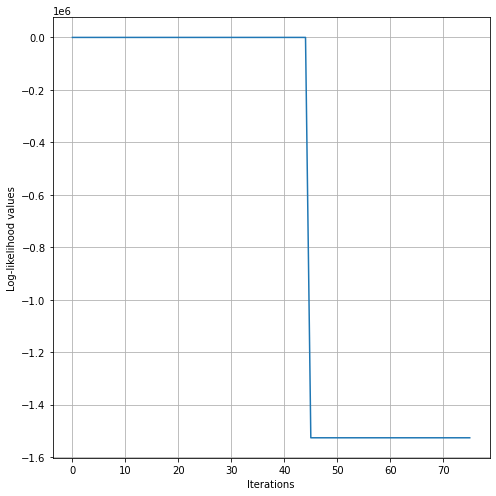

CPU times: user 470 ms, sys: 46 ms, total: 516 ms
Wall time: 484 ms


In [2496]:
%%time
T = 20
if T < 0: 
    beta0 = 0.
    fix_beta = True
algo = 0 # 0: static, 1: w_dyn
if algo == 1: N_real = 1
N_real=10
seed = 1
if algo == 1:
    model = crepd.CRepDyn_w_temp(rseed = seed ,plot_loglik=True,verbose = 1,N_real=N_real,beta0=beta0,undirected=True,
                         flag_data_T=flag_data_T,fix_beta=fix_beta,initialization=init,constraintU = constraintU,
                            max_iter = 500,eta0=0.0,in_parameters= in_parameters,constrained=constrained,ag=ag,bg=bg,fix_eta=False, assortative=assortative)
elif algo == 0:
    model = creps.CRepDyn(rseed = seed ,plot_loglik=True,verbose = 1,N_real=N_real,beta0=beta0,undirected=True,
                         flag_data_T=flag_data_T,fix_beta=fix_beta,initialization=init,
                            max_iter = 500,eta0=0.0,in_parameters= in_parameters,constrained=constrained,ag=ag,bg=bg,fix_eta=False, assortative=assortative)
    
u, v, w,eta,beta, Loglikelihood = model.fit(data=B,T=T, nodes=nodes,K = K)
# out_dict = dict(zip([ 'u', 'v', 'w','eta','beta', 'Loglikelihood'], out))


In [2497]:
w

array([[[0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.88977143e-10]]])

In [2498]:
u_norm = tl.normalize_nonzero_membership(u)
u_norm

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [2499]:
u

array([[       0.        , 10832568.37910088],
       [       0.        ,  6499541.02746053],
       [       0.        ,  6499541.02746053],
       [       0.        ,  6499541.02746053],
       [       0.        ,  6499541.02746053],
       [       0.        , 10832568.37910088]])

In [2500]:
beta

array(0.72727273)

In [2501]:
G0 = nx.Graph(A[0])
G1 = nx.Graph(A[-1])
pos0 =  nx.spring_layout(G0)
pos1 =  nx.spring_layout(G1)

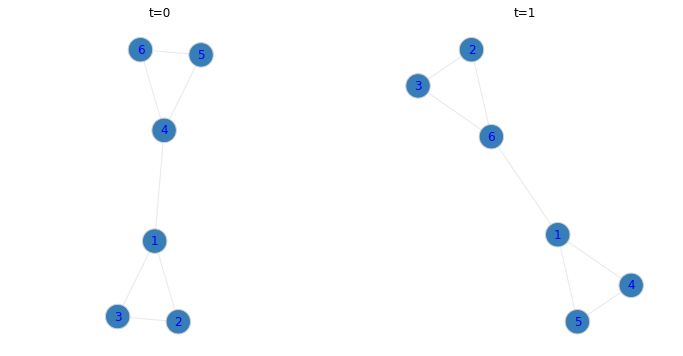

In [2502]:
radius = 0.03
plt.figure(figsize=(12,6))
    
dg = 3

plt.subplot(1, 2, 1)
ax = plt.gca()
nx.draw_networkx_edges(G0, pos0,arrows=False,edge_color='lightgrey',alpha =0.5)
nx.draw_networkx_labels(G0, pos0,font_color='blue',font_size =12)
for nid,n in enumerate(list(G0.nodes())):
    degree_n = G0.degree(n)
    degree_n = dg
    wedge_sizes,wedge_colors = extract_overlapping_membership(nid,cm,u_norm,threshold=0.001)
    if len(wedge_sizes)>0:
        pie,t = plt.pie(wedge_sizes, center=pos0[n], colors = wedge_colors,radius=(min(10,degree_n))*radius,wedgeprops=wedgeprops,normalize=False)
#                 [p.set_zorder(-1) for p in pie]
ax.axis("equal")
plt.title('t=0')

plt.subplot(1, 2, 2)
ax = plt.gca()
nx.draw_networkx_edges(G1, pos1,arrows=False,edge_color='lightgrey',alpha =0.5)
nx.draw_networkx_labels(G1, pos1,font_color='blue',font_size =12)
for nid,n in enumerate(list(G1.nodes())):
    degree_n = G1.degree(n)    
    degree_n = dg
    wedge_sizes,wedge_colors = extract_overlapping_membership(nid,cm,u_norm,threshold=0.001)
    if len(wedge_sizes)>0:
        pie,t = plt.pie(wedge_sizes, center=pos1[n], colors = wedge_colors,radius=(min(10,degree_n))*radius,wedgeprops=wedgeprops,normalize=False)
#                 [p.set_zorder(-1) for p in pie]
ax.axis("equal")
plt.title('t=1')
# plt.savefig('../figures/SBM_overlapping.png',dpi=100,bbox_inches = 'tight',
#     pad_inches = 0)
plt.show()



### Aggregating time steps

In [ ]:
dataset = 'toy_example'
network = infolder + dataset + end_file

In [2230]:
df = pd.read_csv(network,sep='\s+')
df1 = df[['source','target']]
df1['weight_t0'] = np.sum(df.iloc[:,2:].values,axis=1)
df1.head()

<ipython-input-2230-6cc169d8383f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['weight_t0'] = np.sum(df.iloc[:,2:].values,axis=1)


,source,target,weight_t0
0,2,3,2
1,3,2,2
2,4,5,2
3,5,4,2
4,4,1,2


In [2232]:
outfile = infolder+dataset+'_aggr'+end_file
df1.to_csv(outfile,index=False,sep=' ')
outfile

'../data/input/toy_example/toy_example_aggr.dat'

In [2233]:
A_aggr, B_aggr, B_T_aggr, data_T_vals_aggr = tl.import_data(outfile,header=0)
nodes = A_aggr[0].nodes()
pos = nx.spring_layout(A_aggr[0]) 
N = len(nodes)

   source  target  weight_t0
0       2       3          2
1       3       2          2
2       4       5          2
3       5       4          2
4       4       1          2
../data/input/toy_example/toy_example_aggr.dat shape: (22, 3)
number edges: 22
Number of nodes = 6
Number of layers = 1
Number of edges and average degree in each layer:
E[0] = 22 - <k> = 7.333
M[0] = 22 - <k_weighted> = 7.333
Reciprocity (networkX) = 1.0
Reciprocity (intended as the proportion of bi-directional edges over the unordered pairs) = 1.0
Reciprocity (considering the weights of the edges) = 1.0


In [2239]:
B_aggr

array([[[0., 1., 1., 1., 1., 1.],
        [1., 0., 1., 0., 0., 1.],
        [1., 1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1., 1.],
        [1., 0., 0., 1., 0., 1.],
        [1., 1., 1., 1., 1., 0.]]])

In [2244]:
B_aggr[B_aggr.nonzero()].shape

(22,)

u, v and w are initialized randomly.
Updating realization 0 ... done!
Nreal = 0 - Loglikelihood = -3912.185523568656 - iterations = 500 - time = 0.16 seconds
u, v and w are initialized randomly.
Updating realization 1 ... done!
Nreal = 1 - Loglikelihood = -3949.378484457564 - iterations = 500 - time = 0.18 seconds
u, v and w are initialized randomly.
Updating realization 2 ... done!
Nreal = 2 - Loglikelihood = -4000.5955667555913 - iterations = 500 - time = 0.16 seconds
u, v and w are initialized randomly.
Updating realization 3 ... done!
Nreal = 3 - Loglikelihood = -3939.895470428019 - iterations = 500 - time = 0.17 seconds
u, v and w are initialized randomly.
Updating realization 4 ... done!
Nreal = 4 - Loglikelihood = -3905.0452731465525 - iterations = 500 - time = 0.15 seconds
u, v and w are initialized randomly.
Updating realization 5 ... done!
Nreal = 5 - Loglikelihood = -4046.2074970631325 - iterations = 500 - time = 0.16 seconds
u, v and w are initialized randomly.
Updating rea

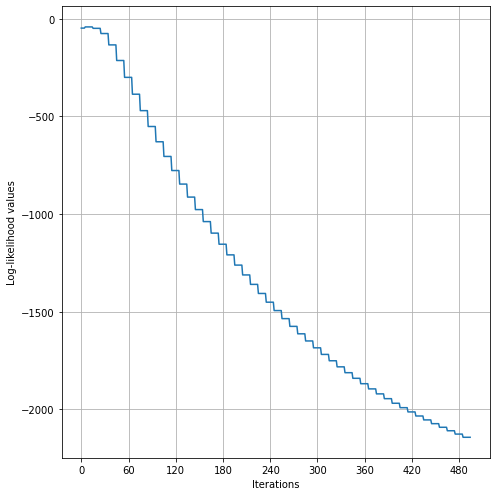

CPU times: user 1.72 s, sys: 91.3 ms, total: 1.82 s
Wall time: 1.75 s


In [2248]:
%%time
T = 1
beta0 = 0.
fix_beta = True
algo = 0 # 0: static, 1: w_dyn

model = creps.CRepDyn(rseed = seed ,plot_loglik=True,verbose = 1,N_real=N_real,beta0=beta0,undirected=True,
                     flag_data_T=flag_data_T,fix_beta=fix_beta,initialization=init,
                        max_iter = 500,eta0=0.0,in_parameters= in_parameters,constrained=constrained,ag=ag,bg=bg,fix_eta=False, assortative=assortative)
    
u_aggr, v_aggr, w_aggr,eta_aggr,beta_aggr, Loglikelihood_aggr = model.fit(data=B_aggr,T=T, nodes=nodes,K = K)
# out_dict = dict(zip([ 'u', 'v', 'w','eta','beta', 'Loglikelihood'], out))


In [2257]:
w

array([[[1.37679997e-01, 3.25047350e-10],
        [2.64390993e-10, 3.55049457e-01]]])

In [2252]:
w_aggr

array([[[0.10733888, 0.        ],
        [0.        , 0.10733888]]])

In [2249]:
u_norm_aggr = tl.normalize_nonzero_membership(u_aggr)
u_norm_aggr

array([[5.00000000e-01, 5.00000000e-01],
       [1.00000000e+00, 2.36652272e-87],
       [1.00000000e+00, 2.43897305e-87],
       [1.21495634e-89, 1.00000000e+00],
       [6.11644822e-90, 1.00000000e+00],
       [5.00000000e-01, 5.00000000e-01]])

In [2255]:
G_aggr = nx.Graph(A_aggr[0])
pos_aggr =  nx.spring_layout(G_aggr)


Text(0.5, 1.0, 't=0')

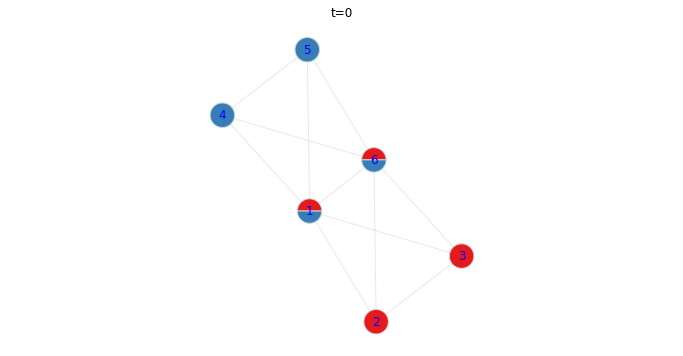

In [2256]:
radius = 0.03
plt.figure(figsize=(12,6))
    
dg = 3

ax = plt.gca()
nx.draw_networkx_edges(G_aggr, pos_aggr,arrows=False,edge_color='lightgrey',alpha =0.5)
nx.draw_networkx_labels(G_aggr, pos_aggr,font_color='blue',font_size =12)
for nid,n in enumerate(list(G_aggr.nodes())):
    degree_n = G_aggr.degree(n)
    degree_n = dg
    wedge_sizes,wedge_colors = extract_overlapping_membership(nid,cm,u_norm_aggr,threshold=0.001)
    if len(wedge_sizes)>0:
        pie,t = plt.pie(wedge_sizes, center=pos_aggr[n], colors = wedge_colors,radius=(min(10,degree_n))*radius,wedgeprops=wedgeprops,normalize=False)
#                 [p.set_zorder(-1) for p in pie]
ax.axis("equal")
plt.title('t=0')



### Cosine Similarity

In [1429]:
u, cs_u = cvfun.cosine_similarity(u,theta['u'])
v, cs_v = cvfun.cosine_similarity(v,theta['v'])
cs_u,cs_v


NameError: name 'theta' is not defined

### A vs M

In [600]:
u.shape,v.shape,w.shape

((6, 2), (6, 2), (4, 2))

In [601]:
M_inf = [expected_Aija(u,v,w[t]) for t in range(w.shape[0])]
M_inf


[array([[0.55839373, 0.39374943, 0.39374943, 0.51697109, 0.42036045,
         0.46015438],
        [0.39374943, 0.29310274, 0.29310274, 0.34404455, 0.30410416,
         0.35313571],
        [0.39374943, 0.29310274, 0.29310274, 0.34404455, 0.30410416,
         0.35313571],
        [0.51697109, 0.34404455, 0.34404455, 0.50580797, 0.37897906,
         0.38800405],
        [0.42036045, 0.30410416, 0.30410416, 0.37897906, 0.32027418,
         0.36066589],
        [0.46015438, 0.35313571, 0.35313571, 0.38800405, 0.36066589,
         0.43235534]]),
 array([[0.14980622, 0.12146505, 0.12146505, 0.11769603, 0.12065109,
         0.15281109],
        [0.12146505, 0.10556568, 0.10556568, 0.0860383 , 0.10134853,
         0.13703339],
        [0.12146505, 0.10556568, 0.10556568, 0.0860383 , 0.10134853,
         0.13703339],
        [0.11769603, 0.0860383 , 0.0860383 , 0.10492563, 0.09011722,
         0.10263797],
        [0.12065109, 0.10134853, 0.10134853, 0.09011722, 0.09892301,
         0.12960534

IndexError: index 4 is out of bounds for axis 0 with size 4

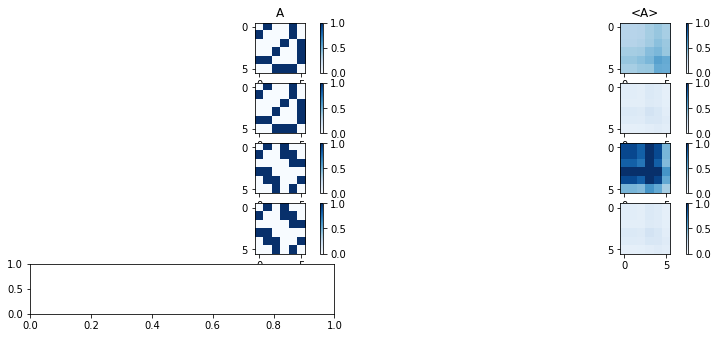

In [602]:
t = 0
plt.figure(figsize=(12,12))
c = 0
for t in range(T):
    plt.subplot(T+1, 2, c+1)
    plt.imshow(B[t][nodelist][:,nodelist], cmap='Blues', interpolation='nearest',vmin=0,vmax=1)
    plt.colorbar(fraction=0.046)
    if c == 0:plt.title('A')
    plt.subplot(T+1, 2, c+2)
    plt.imshow(M_inf[t][nodelist][:,nodelist], cmap='Blues', interpolation='nearest',vmin=0,vmax=1)
    plt.colorbar(fraction=0.046)
    if c == 0:plt.title('<A>')
    c += 2
#     print(np.mean(B[t][nodelist][:,nodelist]-M_inf[t][nodelist][:,nodelist]))
plt.show()

### W

In [ ]:

plt.figure(figsize=(12,6))
for t in range(T):
        plt.subplot(1, 2, t+1)
        plt.imshow(w[t], cmap=cmap, interpolation='nearest')
#         plt.colorbar(fraction=0.046)
        plt.title('<W>')
        c += 2

plt.show()